<a href="https://colab.research.google.com/github/asheemita97-pixel/Spatial-Localization-Dsz/blob/main/co.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ellipse semi-axes: a = 0.997500 µm, b = 0.399000 µm
Grid spacing: dx = 3.536045e-02 µm, dy = 3.536045e-02 µm
Grid shape: ny = 24, nx = 57  -> total grid points = 1368
Points inside ellipse: 995 (target was 1000)
Points array shape: (995, 2)
Mask matrix shape (ny, nx): (24, 57)


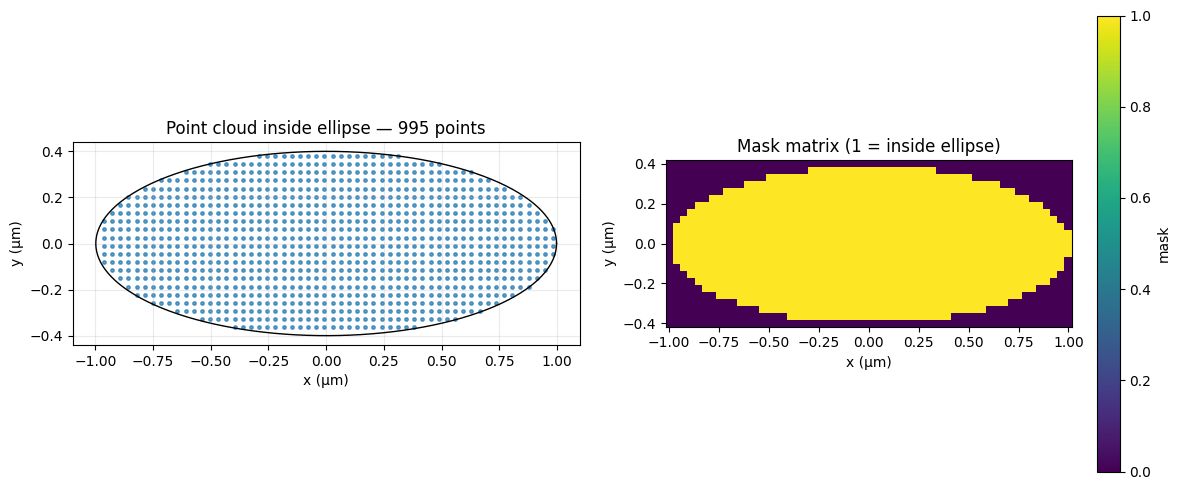

In [ ]:
# produce (ny, nx) mask matrix and (N_points,2) coordinate list, then visualize.
#
# Given:
#   larger diameter = 1.995 um (major axis length)
#   smaller diameter = 0.798 um (minor axis length)
#
# Outputs:
#   X, Y          -> full 2D grid arrays (ny, nx)
#   mask          -> boolean array (ny, nx) True = point inside ellipse
#   points        -> (N_inside, 2) array of (x,y) coordinates inside ellipse
#   dx, dy        -> grid spacing used (equal here)
#   phi           -> example variable array (ny, nx) initialized for FTCS

import numpy as np
import matplotlib.pyplot as plt

major_diam = 1.995    # micrometers (largest diameter)
minor_diam = 0.798    # micrometers (smallest diameter)
target_N = 1000     # approximate number of points inside the ellipse desired
tolerance = 0.05      # +/- tolerance (5%)

a = major_diam / 2.0  # semi-major axis (um)
b = minor_diam / 2.0  # semi-minor axis (um)

area = np.pi * a * b
dx = np.sqrt(area / target_N)
dy = dx

# helper to make grid + mask and return count
def build_grid(dx, dy):
    # ensure grid includes endpoints by adding a half-step margin
    x = np.arange(-a - 1e-12, a + dx/2.0, dx)
    y = np.arange(-b - 1e-12, b + dy/2.0, dy)
    X, Y = np.meshgrid(x, y)
    # ellipse equation (normalized)
    mask = (X / a) ** 2 + (Y / b) ** 2 <= 1.0
    return X, Y, mask

# iteratively adjust dx until N_inside is close to target_N (within tolerance)
max_iters = 30
for it in range(max_iters):
    X, Y, mask = build_grid(dx, dy)
    N_inside = np.count_nonzero(mask)
    if abs(N_inside - target_N) / target_N <= tolerance:
        break
    # adjust spacing using proportional scaling
    scale = np.sqrt(N_inside / target_N)
    dx *= scale
    dy *= scale
else:
    # if loop finishes without break, we still have X,Y,mask from last iteration
    N_inside = np.count_nonzero(mask)

# prepare outputs
points = np.column_stack((X[mask], Y[mask]))   # (N_inside, 2)
ny, nx = X.shape
mask_int = mask.astype(int)  # 1 inside, 0 outside
phi = np.zeros_like(X)       # example variable matrix for FTCS (same shape)

# print summary
print(f"Ellipse semi-axes: a = {a:.6f} µm, b = {b:.6f} µm")
print(f"Grid spacing: dx = {dx:.6e} µm, dy = {dy:.6e} µm")
print(f"Grid shape: ny = {ny}, nx = {nx}  -> total grid points = {nx*ny}")
print(f"Points inside ellipse: {N_inside} (target was {target_N})")
print(f"Points array shape: {points.shape}")
print("Mask matrix shape (ny, nx):", mask.shape)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# 1) scatter plot of points (good for checking distribution)
ax = axes[0]
ax.scatter(points[:,0], points[:,1], s=6, alpha=0.7)
# overlay ellipse boundary
theta = np.linspace(0, 2*np.pi, 400)
xb = a * np.cos(theta)
yb = b * np.sin(theta)
ax.plot(xb, yb, color='k', linewidth=1)
ax.set_aspect('equal', 'box')
ax.set_title(f'Point cloud inside ellipse — {N_inside} points')
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.grid(alpha=0.25)

# 2) mask visualization as pcolormesh (useful to see the matrix layout)
ax = axes[1]
# pcolormesh requires corner coordinates; construct edges
x_edges = np.linspace(-a - dx/2.0, a + dx/2.0, nx+1)
y_edges = np.linspace(-b - dy/2.0, b + dy/2.0, ny+1)
# show mask as image-like plot
pcm = ax.pcolormesh(x_edges, y_edges, mask_int, shading='auto')
ax.set_aspect('equal', 'box')
ax.set_title('Mask matrix (1 = inside ellipse)')
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
fig.colorbar(pcm, ax=ax, label='mask')

plt.tight_layout()
plt.show()

# --- Useful helpers for FTCS ---f

# To use FTCS on this domain, keep phi (ny,nx) and mask.
# Example: iterate only over interior points (exclude outside points)
# Note: indexing is phi[row, col] corresponding to Y[row,:], X[:,col]
#
# Example FTCS update pseudo-code (explicit diffusion, 2D) for interior points:
#
# alpha = D * dt / dx**2   # diffusion number (choose dt accordingly)
# for it in range(num_steps):
#     phi_new = phi.copy()
#     # update only where mask is True and not on boundary if you want Dirichlet boundary
#     interior_idx = np.where(mask)   # returns (rows, cols)
#     rows, cols = interior_idx
#     # vectorized neighbor access example (careful at domain edges: mask handles outside)
#     # here we demonstrate a safe neighbor-sum using shifts:
#     # neighbor_sum = (phi[rows+1, cols] + phi[rows-1, cols] + phi[rows, cols+1] + phi[rows, cols-1])
#     # phi_new[rows, cols] = phi[rows, cols] + alpha * (neighbor_sum - 4*phi[rows,cols])
#     # apply boundary conditions (Dirichlet or Neumann) as needed.
#
# Save arrays for later:
# np.save("ellipse_points.npy", points)
# np.save("ellipse_mask.npy", mask_int)


--- computing polynomial distributions ---
Processing E1_eqn.json...
Processing E2_eqn.json...
Processing E3_eqn.json...
Processing Substrate (uniform throughout cell)...


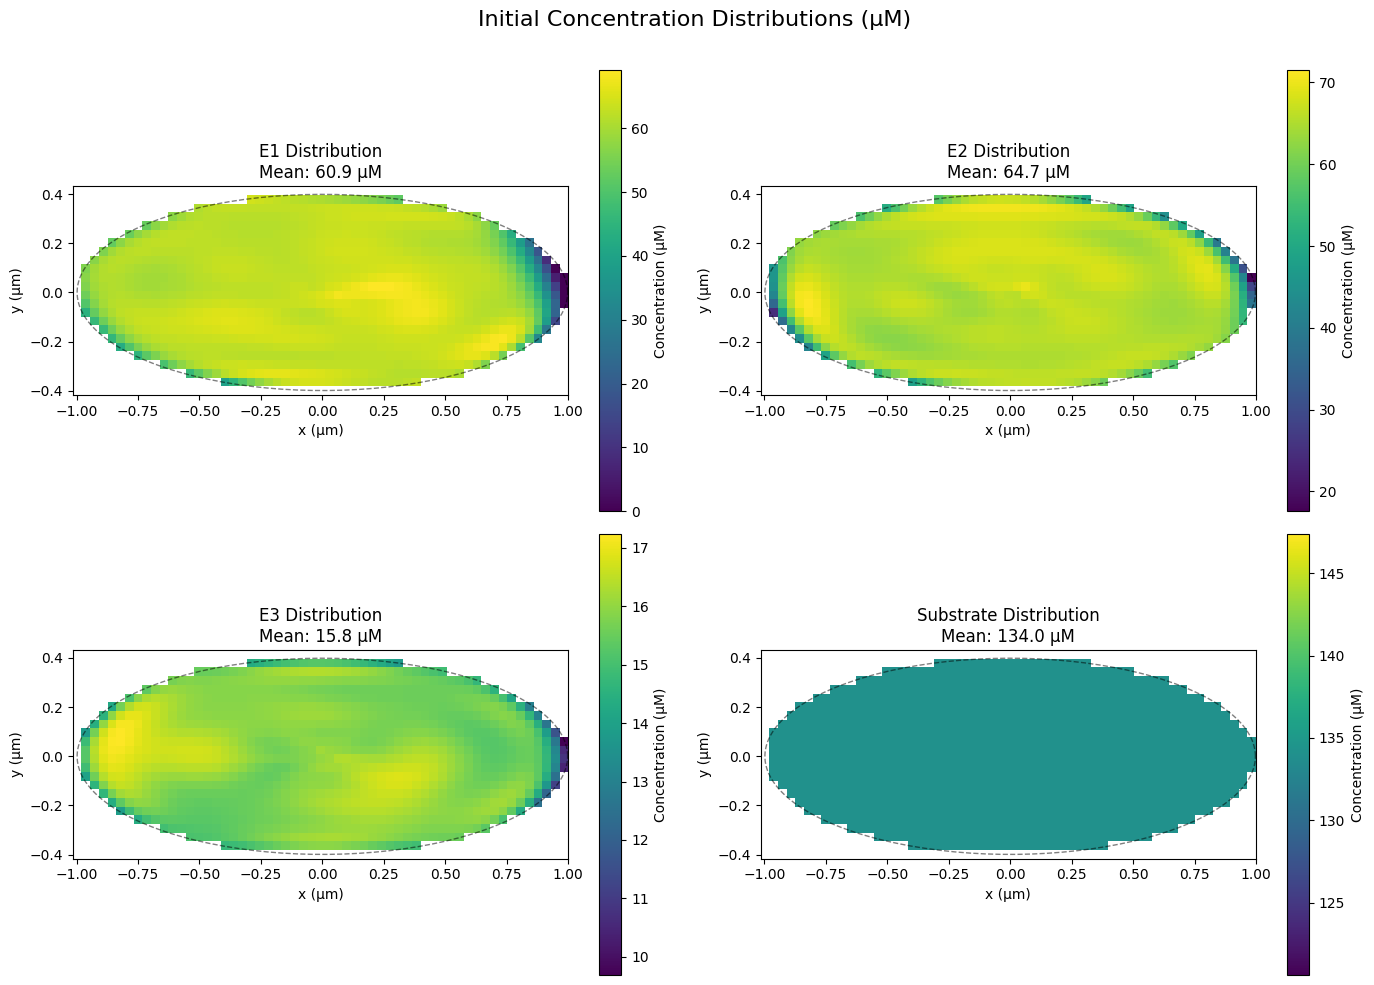


--- Validation ---
E1 Global Average: 60.90 µM (Target: 60.9)
E2 Global Average: 64.70 µM (Target: 64.7)
E3 Global Average: 15.80 µM (Target: 15.8)
Substrate Global Average: 134.00 µM (Target: 134.0)


In [ ]:
import json
import os
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import numpy as np
import re

# ==============================================================================
# 1. HELPER FUNCTIONS
# ==============================================================================

def get_ellipse_coords(X, Y, a, b):
    """
    Returns normalized radius (rho) and angle (theta) in the transformed
    unit-circle space of the ellipse.
    rho = 1.0 at the boundary.
    theta ranges from -pi to pi.
    """
    # Transform to unit circle space
    x_norm = X / a
    y_norm = Y / b

    rho = np.sqrt(x_norm**2 + y_norm**2)
    theta = np.arctan2(y_norm, x_norm)

    return rho, theta

def parse_term_label(label):
    """
    Parses different label styles into (func_name, k, n).
    Supports:
      - "cos2_r^3"          -> ('cos', 2, 3)
      - "sin1_r^0"          -> ('sin', 1, 0)
      - "k1_cos_n2"         -> ('cos', 1, 2)
      - "k0_cos_n0"         -> ('cos', 0, 0)
    """
    # Try format: k{K}_{cos|sin}_n{N}  (example file)
    m = re.match(r'^k(?P<k>\d+)_(?P<type>cos|sin)_n(?P<n>\d+)$', label)
    if m:
        func_type = m.group('type')
        k = int(m.group('k'))
        n = int(m.group('n'))
        return func_type, k, n

    # Try old format: e.g., "cos2_r^3" or "sin1_r^0"
    # allow "cos2_r^3", "sin1_r^0", maybe "cos_r^2" (no freq) etc.
    try:
        trig_part, rad_part = label.split('_', 1)
    except ValueError:
        raise ValueError(f"Unrecognized term label format: {label}")

    # trig_part like 'cos2' or 'sin1' or 'cos'
    m2 = re.match(r'^(cos|sin)(?P<k>\d*)$', trig_part)
    if not m2:
        raise ValueError(f"Unknown trig function in {label}")

    func_type = m2.group(1)
    k_str = m2.group('k')
    k = int(k_str) if k_str != '' else 1  # default freq 1 if omitted (safe fallback)

    # rad_part expected like 'r^3' or 'r^0'
    m3 = re.match(r'^r\^(?P<n>\d+)$', rad_part)
    if not m3:
        raise ValueError(f"Unknown radial power format in {label}")

    n = int(m3.group('n'))

    return func_type, k, n

def find_json_file(filename):
    """
    Try locating filename in common locations. Returns full path or None.
    Looks in:
      - absolute path if filename is absolute
      - ./filename
      - /mnt/data/filename
      - /content/filename
      - case-insensitive matches in /mnt/data and cwd (if exact not found)
    """
    # if user passed absolute path
    if os.path.isabs(filename) and os.path.exists(filename):
        return filename

    # try cwd
    cwd_candidate = os.path.join(os.getcwd(), filename)
    if os.path.exists(cwd_candidate):
        return cwd_candidate

    # /mnt/data (common for uploaded files)
    mnt_candidate = os.path.join('/mnt/data', filename)
    if os.path.exists(mnt_candidate):
        return mnt_candidate

    # /content (colab style)
    content_candidate = os.path.join('/content', filename)
    if os.path.exists(content_candidate):
        return content_candidate

    # try case-insensitive search in /mnt/data and cwd
    for base in [os.getcwd(), '/mnt/data', '/content']:
        if not os.path.isdir(base):
            continue
        try:
            for fname in os.listdir(base):
                if fname.lower() == filename.lower():
                    return os.path.join(base, fname)
        except PermissionError:
            continue

    return None

def load_polynomial_distribution(filename, rho, theta, mask):
    """
    Reconstructs the distribution from JSON coefficients.
    Basis: coeff * trig(k*theta) * rho^n

    Handles multiple JSON formats:
      - {"term_labels": [...], "coeffs": [...]}
      - {"meta": {"term_order": [...]}, "coeffs": [...]}
      - Or other variants where 'term_labels' or 'term_order' are present.
    """
    # locate file in common places (supports uploaded example in /mnt/data)
    file_path = find_json_file(filename)
    if file_path is None:
        print(f"Warning: {filename} not found in common locations. Returning uniform 0.")
        return np.zeros_like(rho)

    # load JSON
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return np.zeros_like(rho)

    # Determine label list
    labels = None
    if isinstance(data, dict):
        if "term_labels" in data and isinstance(data["term_labels"], list):
            labels = data["term_labels"]
        elif "term_order" in data and isinstance(data["term_order"], list):
            labels = data["term_order"]
        elif "meta" in data and isinstance(data["meta"], dict) and "term_order" in data["meta"]:
            labels = data["meta"]["term_order"]
        # some files might use "labels"
        elif "labels" in data and isinstance(data["labels"], list):
            labels = data["labels"]

    coeffs = data.get("coeffs", None)
    if coeffs is None or labels is None:
        print(f"Error: {os.path.basename(file_path)} missing 'coeffs' or term label info. Returning zeros.")
        return np.zeros_like(rho)

    # Ensure labels and coeffs align; if lengths mismatch, use minimal length and warn
    if len(labels) != len(coeffs):
        min_len = min(len(labels), len(coeffs))
        if min_len == 0:
            print(f"Error: No usable terms in {os.path.basename(file_path)}. Returning zeros.")
            return np.zeros_like(rho)
        print(f"Warning: label/coeff length mismatch in {os.path.basename(file_path)} "
              f"({len(labels)} labels, {len(coeffs)} coeffs). Truncating to {min_len}.")
        labels = labels[:min_len]
        coeffs = coeffs[:min_len]

    # Accumulate distribution
    dist_map = np.zeros_like(rho, dtype=float)

    for label, C in zip(labels, coeffs):
        if C == 0:
            continue

        # parse label robustly (supports both styles)
        try:
            func_type, k, n = parse_term_label(label)
        except ValueError as e:
            # skip unknown labels but warn
            print(f"Warning: skipping term '{label}' due to parse error: {e}")
            continue

        # radial power
        radial_term = rho ** n

        # angular term: handle k==0 properly (cos(0)=1, sin(0)=0)
        if func_type == 'cos':
            angular_term = np.cos(k * theta)
        else:
            angular_term = np.sin(k * theta)

        dist_map += float(C) * angular_term * radial_term

    # Mask outside points
    dist_map[~mask] = 0.0

    # Clip negative values if any (concentrations cannot be negative)
    if np.any(dist_map[mask] < 0):
        dist_map[dist_map < 0] = 0.0

    return dist_map

def normalize_to_total(dist_map, mask, target_avg_conc):
    """
    Normalizes the distribution such that the average concentration
    over the masked area equals target_avg_conc.
    """
    current_avg = np.mean(dist_map[mask])
    if current_avg == 0:
        return dist_map
    scale = target_avg_conc / current_avg
    return dist_map * scale

# ==============================================================================
# 2. COMPUTE MAPS
# ==============================================================================

print("--- computing polynomial distributions ---")

# A. Coordinate Systems
rho, theta = get_ellipse_coords(X, Y, a, b)

# B. Map Enzymes E1, E2, E3
targets = {
    "E1": 60.9,
    "E2": 64.7,
    "E3": 15.8
}

maps = {}

for name, target_conc in targets.items():
    filename = f"{name}_eqn.json"
    print(f"Processing {filename}...")

    # 1. Reconstruct raw shape from coefficients
    raw_dist = load_polynomial_distribution(filename, rho, theta, mask)

    # 2. Normalize to meet the 'Total Concentration' requirement
    # (Interpreted as global average concentration)
    maps[name] = normalize_to_total(raw_dist, mask, target_conc)

# C. Map Substrate (Uniform throughout cell)
# Defined: 134 uM, spread uniformly across the cell interior (mask)
print("Processing Substrate (uniform throughout cell)...")
target_S_conc = 134.0

# Create uniform substrate within the mask
S_map = np.zeros_like(X)
S_map[mask] = 1.0

# Normalize substrate to desired average inside mask
maps["Substrate"] = normalize_to_total(S_map, mask, target_S_conc)


# ==============================================================================
# 3. VISUALIZATION
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Initial Concentration Distributions (µM)", fontsize=16)

plot_list = [
    ("E1", maps["E1"], axes[0,0]),
    ("E2", maps["E2"], axes[0,1]),
    ("E3", maps["E3"], axes[1,0]),
    ("Substrate", maps["Substrate"], axes[1,1])
]

for name, data, ax in plot_list:
    # Plot masked array
    masked_data = np.ma.masked_where(~mask, data)

    # Dynamic coloring based on range inside mask
    vmin = data[mask].min()
    vmax = data[mask].max()

    pcm = ax.pcolormesh(X, Y, masked_data, shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)

    avg_val = np.mean(data[mask])
    ax.set_title(f"{name} Distribution\nMean: {avg_val:.1f} µM")
    ax.set_aspect('equal')
    ax.set_xlabel('x (µm)')
    ax.set_ylabel('y (µm)')

    # Draw boundary
    th_plot = np.linspace(0, 2*np.pi, 200)
    ax.plot(a*np.cos(th_plot), b*np.sin(th_plot), 'k--', lw=1, alpha=0.5)

    fig.colorbar(pcm, ax=ax, label='Concentration (µM)')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# ==============================================================================
# 4. EXPORT FOR FTCS
# ==============================================================================
# Save these maps to a dictionary 'concentration_maps' for the next step
concentration_maps = maps

print("\n--- Validation ---")
for k, v in maps.items():
    print(f"{k} Global Average: {np.mean(v[mask]):.2f} µM (Target: {targets.get(k, target_S_conc)})")


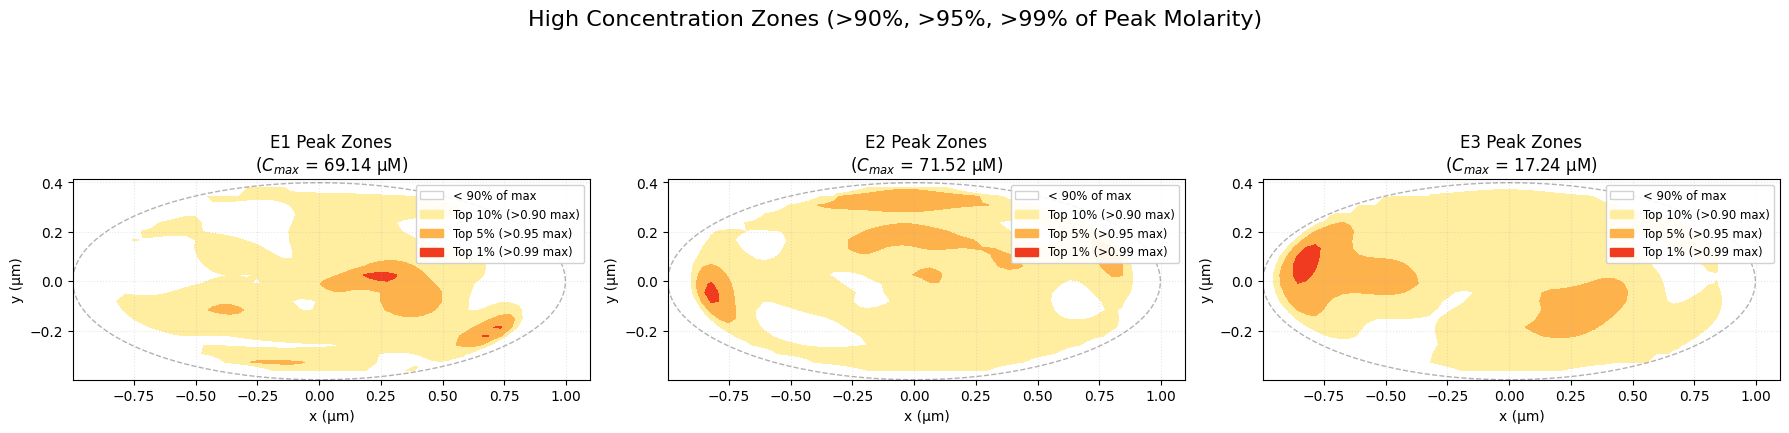

In [ ]:
import matplotlib.patches as mpatches

# ==============================================================================
# VISUALIZATION: HIGH CONCENTRATION ZONES (HOTSPOTS)
# ==============================================================================

def plot_hotspots(concentration_maps, X, Y, mask, a, b):
    """
    Visualizes regions where concentration exceeds 90%, 95%, and 99%
    of the global maximum for each enzyme.
    """
    enzymes = ['E1', 'E2', 'E3']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle("High Concentration Zones (>90%, >95%, >99% of Peak Molarity)", fontsize=16)

    # Define colors for the thresholds
    # 90-95% (Yellow), 95-99% (Orange), 99-100% (Red)
    colors = ['#FFEDA0', '#FEB24C', '#F03B20']
    labels = ['Top 10% (>0.90 max)', 'Top 5% (>0.95 max)', 'Top 1% (>0.99 max)']

    for i, name in enumerate(enzymes):
        ax = axes[i]
        data = concentration_maps[name]

        # 1. Determine the Peak Concentration (C_max)
        # We only consider points inside the ellipse
        valid_data = data[mask]
        c_max = valid_data.max()

        # 2. Define contour levels relative to C_max
        levels = [0.90 * c_max, 0.95 * c_max, 0.99 * c_max, c_max * 1.001]

        # 3. Plot the ellipse boundary (context)
        theta_plot = np.linspace(0, 2*np.pi, 200)
        ax.plot(a*np.cos(theta_plot), b*np.sin(theta_plot), 'k--', lw=1, alpha=0.3)

        # 4. Fill the contours
        # We mask the data again just to be safe for the plot
        data_masked = np.ma.masked_where(~mask, data)

        # Contourf fills intervals: [0.90, 0.95), [0.95, 0.99), [0.99, Max]
        cs = ax.contourf(X, Y, data_masked, levels=levels, colors=colors, extend='max')

        # 5. Aesthetics
        ax.set_title(f"{name} Peak Zones\n($C_{{max}}$ = {c_max:.2f} µM)")
        ax.set_aspect('equal')
        ax.set_xlabel('x (µm)')
        ax.set_ylabel('y (µm)')
        ax.grid(True, which='both', linestyle=':', alpha=0.3)

        # 6. Custom Legend
        patches = [mpatches.Patch(color=colors[j], label=labels[j]) for j in range(3)]
        # Add a patch for the background (rest of cell)
        patches.insert(0, mpatches.Patch(color='white', label='< 90% of max', ec='lightgray'))
        ax.legend(handles=patches, loc='upper right', fontsize='small', framealpha=0.9)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Run the visualization
plot_hotspots(concentration_maps, X, Y, mask, a, b)

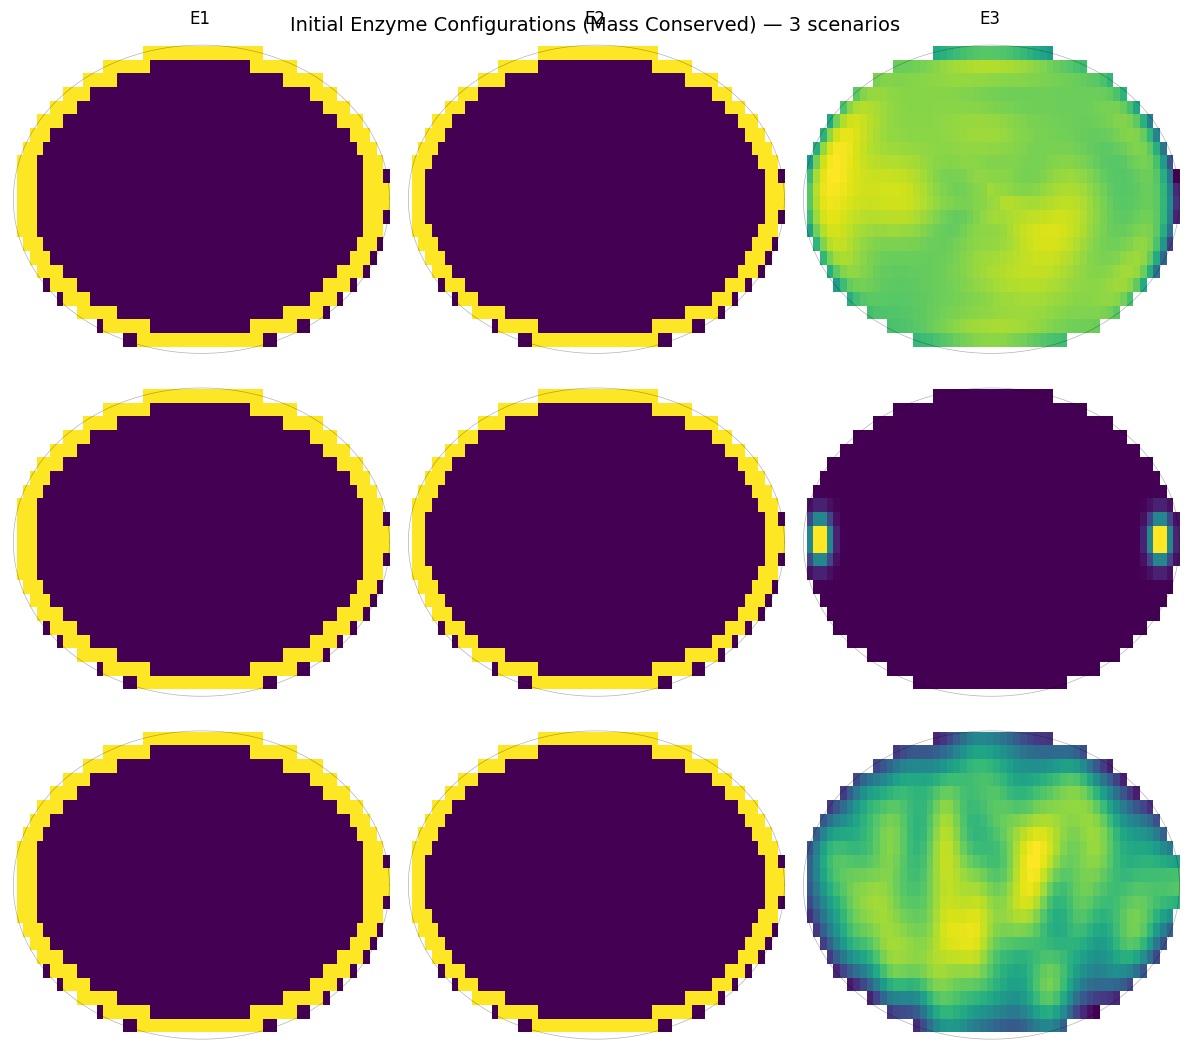

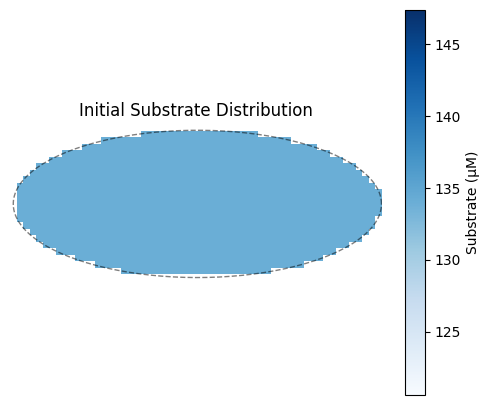

[solver] dx=3.536e-02, dt=2.813e-06, steps_per_chunk=3555, num_snapshots=2000


Case 1 (rings + E3 original):   0%|          | 0/2000 [00:00<?, ?it/s]

Case 2 (rings + E3 poles):   0%|          | 0/2000 [00:00<?, ?it/s]

Case 3 (rings + E3 random + E3 diff):   0%|          | 0/2000 [00:00<?, ?it/s]

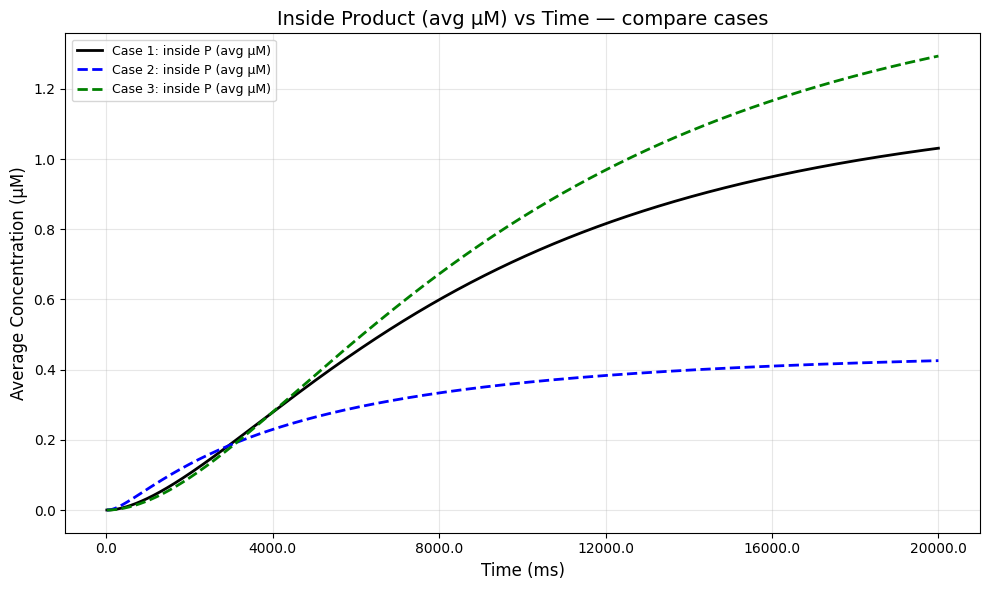

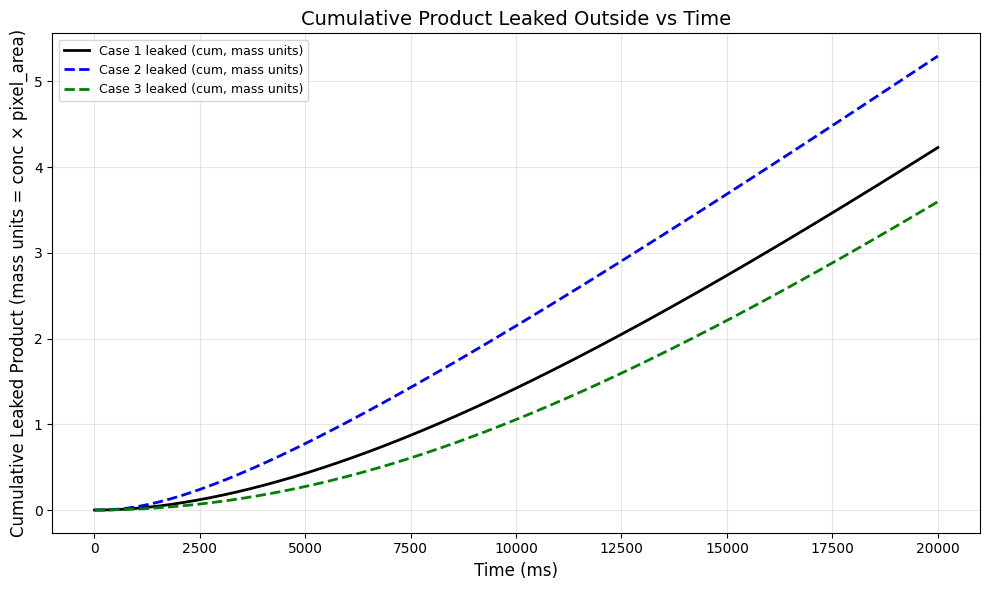


Final summary (inside avg conc µM, leaked cumulative mass):
Case1: inside final avg µM = 1.0312e+00, leaked total mass = 4.2287e+00
Case2: inside final avg µM = 4.2571e-01, leaked total mass = 5.2962e+00
Case3: inside final avg µM = 1.2939e+00, leaked total mass = 3.5971e+00

--- Generating GIFs ---
Generating Case1_S.gif...
Generating Case1_I1.gif...
Generating Case1_I2.gif...
Generating Case1_P.gif...
Generating Case2_S.gif...
Generating Case2_I1.gif...
Generating Case2_I2.gif...
Generating Case2_P.gif...
Generating Case3_S.gif...
Generating Case3_I1.gif...
Generating Case3_I2.gif...
Generating Case3_P.gif...
All done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from numba import njit
from tqdm.notebook import tqdm
import scipy.ndimage as nd
import matplotlib.ticker as mticker

# ======================================================================
# ASSUMPTION: the following names exist in your notebook environment:
# mask (2D boolean), X, Y (2D coordinate grids), a, b, dx, concentration_maps
# ======================================================================

# -------------------
# 1. HELPER FUNCTIONS
# -------------------

def add_padding(arr):
    return np.pad(arr, pad_width=1, mode='constant', constant_values=0)

def remove_padding(arr):
    return arr[1:-1, 1:-1]

def create_spread_random(mask, total_mass, sigma=1, seed=None):
    """
    Creates a spread-out random distribution across the mask while conserving mass.
    """
    if seed is not None:
        rs = np.random.RandomState(seed)
        noise = rs.rand(*mask.shape)
    else:
        noise = np.random.rand(*mask.shape)

    noise[~mask] = 0.0
    noise = nd.gaussian_filter(noise, sigma=sigma)
    noise[~mask] = 0.0

    current_mass = np.sum(noise)
    if current_mass > 0:
        noise *= (total_mass / current_mass)
    else:
        noise[mask] = total_mass / np.count_nonzero(mask)

    return noise

def diffuse_enzyme_via_gaussian(E_padded, D, delta_t, dx, mask):
    """
    Approximate solution of dE/dt = D ∇^2 E over time delta_t using a Gaussian blur,
    conserving total mass within the mask.
    """
    E = remove_padding(E_padded)
    mass_before = np.sum(E[mask])
    if mass_before == 0:
        return E_padded

    # sigma in grid units: sqrt(2*D*delta_t) / dx
    sigma_pixels = np.sqrt(max(0.0, 2.0 * D * max(1e-16, delta_t))) / dx
    if sigma_pixels <= 0.001:
        return E_padded

    E_blurred = nd.gaussian_filter(E, sigma=sigma_pixels)
    E_blurred[~mask] = 0.0

    mass_after = np.sum(E_blurred[mask])
    if mass_after > 0:
        E_blurred *= (mass_before / mass_after)
    else:
        E_blurred[mask] = mass_before / np.count_nonzero(mask)

    return add_padding(E_blurred)

# ------------------------------
# 2. PREPARE MAPS FOR 3 SCENARIOS
# ------------------------------

S_raw = concentration_maps['Substrate'].copy()

# Fix substrate rim if empty (as before)
if np.sum(S_raw) == 0:
    struct = nd.generate_binary_structure(2, 1)
    mask_rim = mask ^ nd.binary_erosion(mask, structure=struct, iterations=1)
    S_raw[:] = 0; S_raw[mask_rim] = 1.0
    S_raw *= (134.0 / np.mean(S_raw[mask]))

# Originals
E1_orig = concentration_maps['E1'].copy()
E2_orig = concentration_maps['E2'].copy()
E3_orig = concentration_maps['E3'].copy()

mass_E1 = np.sum(E1_orig[mask])
mass_E2 = np.sum(E2_orig[mask])
mass_E3 = np.sum(E3_orig[mask])

# Randomized counterpart for E3 (used in case 3)
E3_rand = create_spread_random(mask, mass_E3, sigma=2, seed=103)

# --- Build concentric overlapping rings for E1 & E2 near the membrane
# Center coordinates (robust)
xc = 0.5 * (X.min() + X.max())
yc = 0.5 * (Y.min() + Y.max())

# normalized radius relative to cell ellipse (uses provided a,b)
r_norm = np.sqrt(((X - xc) / (a + 1e-12))**2 + ((Y - yc) / (b + 1e-12))**2)

# Design two slightly different thin ring windows so they are concentric and overlap
# E1: slightly wider inner ring, E2: slightly narrower inner ring (both hugging membrane)
e1_inner = 0.88
e1_outer = 0.995
e2_inner = 0.90
e2_outer = 0.995

E1_ring = np.zeros_like(E1_orig)
E2_ring = np.zeros_like(E2_orig)

e1_mask = (r_norm >= e1_inner) & (r_norm <= e1_outer) & mask
e2_mask = (r_norm >= e2_inner) & (r_norm <= e2_outer) & mask

# fallback widen if masks are empty
if np.count_nonzero(e1_mask) == 0:
    e1_mask = (r_norm >= 0.85) & (r_norm <= 1.0) & mask
if np.count_nonzero(e2_mask) == 0:
    e2_mask = (r_norm >= 0.85) & (r_norm <= 1.0) & mask

if np.count_nonzero(e1_mask) > 0:
    E1_ring[e1_mask] = 1.0
    # conserve E1 mass
    s = np.sum(E1_ring[mask])
    if s > 0:
        E1_ring *= (mass_E1 / s)
else:
    E1_ring = E1_orig.copy()

if np.count_nonzero(e2_mask) > 0:
    E2_ring[e2_mask] = 1.0
    # conserve E2 mass
    s2 = np.sum(E2_ring[mask])
    if s2 > 0:
        E2_ring *= (mass_E2 / s2)
else:
    E2_ring = E2_orig.copy()

# E3 pole clusters (two small clusters near +/- x-axis ends) - unchanged
cluster_radius = 0.05 * max(a, b)
cluster1_center = (xc + 0.9 * a, yc)
cluster2_center = (xc - 0.9 * a, yc)

dist1 = np.sqrt((X - cluster1_center[0])**2 + (Y - cluster1_center[1])**2)
dist2 = np.sqrt((X - cluster2_center[0])**2 + (Y - cluster2_center[1])**2)

cluster_mask = ((dist1 <= cluster_radius) | (dist2 <= cluster_radius)) & mask
E3_clusters = np.zeros_like(E3_orig)
if np.count_nonzero(cluster_mask) > 0:
    E3_clusters[cluster_mask] = 1.0
    E3_clusters = nd.gaussian_filter(E3_clusters, sigma=1)
    E3_clusters[~mask] = 0.0
    if np.sum(E3_clusters[mask]) > 0:
        E3_clusters *= (mass_E3 / np.sum(E3_clusters[mask]))
    else:
        E3_clusters = create_spread_random(mask, mass_E3, sigma=1, seed=104)
else:
    E3_clusters = create_spread_random(mask, mass_E3, sigma=1, seed=104)

# Case definitions (only 3 now)
# Use E1_ring and E2_ring (concentric overlapping rings) for E1 and E2 in ALL cases
Case1_E1, Case1_E2, Case1_E3 = E1_ring.copy(), E2_ring.copy(), E3_orig.copy()
Case2_E1, Case2_E2, Case2_E3 = E1_ring.copy(), E2_ring.copy(), E3_clusters.copy()
Case3_E1, Case3_E2, Case3_E3 = E1_ring.copy(), E2_ring.copy(), E3_rand.copy()

# diffusion flags per case (only E3 diffused in case 3)
Diff_case1 = (False, False, False)
Diff_case2 = (False, False, False)
Diff_case3 = (False, False, True)

# ------------------------------
# 3. VISUALIZE INITIAL CONFIGS (3 rows)
# ------------------------------

fig, axes = plt.subplots(3, 3, figsize=(12, 11))
fig.suptitle("Initial Enzyme Configurations (Mass Conserved) — 3 scenarios", fontsize=14, y=0.95)

scenarios_viz = [
    ("Case 1: rings (E1/E2) + E3 original",    Case1_E1, Case1_E2, Case1_E3),
    ("Case 2: rings (E1/E2) + E3 poles", Case2_E1, Case2_E2, Case2_E3),
    ("Case 3: rings (E1/E2) + E3 random", Case3_E1, Case3_E2, Case3_E3)
]

cols = ["E1", "E2", "E3"]

for i, (title, e1, e2, e3) in enumerate(scenarios_viz):
    maps_row = [e1, e2, e3]
    axes[i, 0].set_ylabel(title, fontsize=10, rotation=90, labelpad=20)
    for j, m in enumerate(maps_row):
        masked = np.ma.masked_where(~mask, m)
        pcm = axes[i, j].pcolormesh(X, Y, masked, shading='auto', cmap='viridis')
        if i == 0:
            axes[i, j].set_title(cols[j], fontsize=12)
        axes[i, j].axis('off')
        th = np.linspace(0, 2*np.pi, 200)
        axes[i, j].plot(a*np.cos(th), b*np.sin(th), 'k-', lw=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------
# Substrate map visualization (unchanged)
# ------------------------------
plt.figure(figsize=(6, 5))
masked_S = np.ma.masked_where(~mask, S_raw)
if np.count_nonzero(mask) > 0:
    vmin = S_raw[mask].min()
    vmax = S_raw[mask].max()
else:
    vmin, vmax = 0.0, 1.0
pcm_s = plt.pcolormesh(X, Y, masked_S, shading='auto', cmap='Blues', vmin=vmin, vmax=vmax)
plt.colorbar(pcm_s, label='Substrate (µM)')
plt.title("Initial Substrate Distribution")
th_plot = np.linspace(0, 2*np.pi, 200)
plt.plot(a*np.cos(th_plot), b*np.sin(th_plot), 'k--', lw=1, alpha=0.5)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()
# ------------------------------

# --------------------------------------
# 4. SIMULATION CONSTANTS & ROBUST DT
# --------------------------------------

# Run until steady-state (or until max_time)
total_time = 20          # maximum seconds (upper cap)
snapshot_interval = 0.01  # seconds
num_snapshots = int(total_time / snapshot_interval)

# Small-molecule diffusion (set to 10 as requested)
D_S, D_I1, D_I2, D_P = 0.01, 0.01, 0.01, 0.01

# Enzyme diffusion: only E3 may diffuse (case 3) - default zero
D_E1, D_E2, D_E3_default = 0.0, 0.0, 0.0
D_E3_case3 = 1e-2  # for case 3 only

k_cat1 = 0.93 / 60.0
k_cat2 = 12.02 / 60.0
k_cat3 = 1.08 / 60.0
Km1, Km2, Km3 = 1.11, 4.50, 0.94

if 'dx' not in globals():
    raise RuntimeError("dx not defined.")
if dx <= 0:
    raise ValueError("dx must be > 0.")

all_D_small = [D_S, D_I1, D_I2, D_P]
max_D_small = max([float(d) if d is not None else 0.0 for d in all_D_small])
dt_stability = (0.25 * dx**2) / max_D_small
dt = dt_stability * 0.00009
if dt <= 0: dt = 1e-12

steps_per_chunk = int(round(snapshot_interval / dt))
if steps_per_chunk < 1: steps_per_chunk = 1

mask_int = add_padding(mask).astype(np.int32)
S_pad = add_padding(S_raw)
ny, nx = S_pad.shape
n_pixels = np.count_nonzero(mask)
pixel_area = dx * dx
total_area = n_pixels * pixel_area

print(f"[solver] dx={dx:.3e}, dt={dt:.3e}, steps_per_chunk={steps_per_chunk}, num_snapshots={num_snapshots}")

# -----------------------
# 5. NUMBA SOLVER (w/ leakage tracking, absolute mass)
# -----------------------

# fraction of product crossing membrane that is lost to outside (70% leak)
LEAK_FRACTION = 0.7

@njit(fastmath=True)
def run_simulation(S, I1, I2, P, E1, E2, E3, mask_int, dx, dt, steps, leak_frac):
    """
    Returns S,I1,I2,P and (production_total_mass, leaked_mass_estimate)
    Units: "mass units" = concentration * pixel area (dx*dx).
    """
    ny, nx = S.shape

    alpha_S = D_S * dt / dx**2
    alpha_I1 = D_I1 * dt / dx**2
    alpha_I2 = D_I2 * dt / dx**2
    alpha_P = D_P * dt / dx**2

    production_total_mass = 0.0
    leaked_total_mass = 0.0

    S_n = S.copy(); I1_n = I1.copy(); I2_n = I2.copy(); P_n = P.copy()

    # pixel area for mass conversion
    pix_area = dx * dx

    for _ in range(steps):
        for y in range(1, ny-1):
            for x in range(1, nx-1):
                if mask_int[y, x] == 1:
                    s = S[y,x]; i1 = I1[y,x]; i2 = I2[y,x]; p = P[y,x]

                    # S neighbors (Neumann-like reflective within mask) -> no flux to outside
                    s_u = S[y-1,x] if mask_int[y-1,x] else s
                    s_d = S[y+1,x] if mask_int[y+1,x] else s
                    s_l = S[y,x-1] if mask_int[y,x-1] else s
                    s_r = S[y,x+1] if mask_int[y,x+1] else s

                    # I1 neighbors (reflective)
                    i1_u = I1[y-1,x] if mask_int[y-1,x] else i1
                    i1_d = I1[y+1,x] if mask_int[y+1,x] else i1
                    i1_l = I1[y,x-1] if mask_int[y,x-1] else i1
                    i1_r = I1[y,x+1] if mask_int[y,x+1] else i1

                    # I2 neighbors (reflective)
                    i2_u = I2[y-1,x] if mask_int[y-1,x] else i2
                    i2_d = I2[y+1,x] if mask_int[y+1,x] else i2
                    i2_l = I2[y,x-1] if mask_int[y,x-1] else i2
                    i2_r = I2[y,x+1] if mask_int[y,x+1] else i2

                    # P neighbors: if neighbor outside mask -> reduced neighbor (simulates loss)
                    # Also estimate leakage: for each outside neighbor we add approx. alpha_P * leak_frac * p (mass lost)
                    if mask_int[y-1,x]:
                        p_u = P[y-1,x]
                    else:
                        p_u = p * (1.0 - leak_frac)
                        leaked_total_mass += alpha_P * leak_frac * p * pix_area

                    if mask_int[y+1,x]:
                        p_d = P[y+1,x]
                    else:
                        p_d = p * (1.0 - leak_frac)
                        leaked_total_mass += alpha_P * leak_frac * p * pix_area

                    if mask_int[y,x-1]:
                        p_l = P[y,x-1]
                    else:
                        p_l = p * (1.0 - leak_frac)
                        leaked_total_mass += alpha_P * leak_frac * p * pix_area

                    if mask_int[y,x+1]:
                        p_r = P[y,x+1]
                    else:
                        p_r = p * (1.0 - leak_frac)
                        leaked_total_mass += alpha_P * leak_frac * p * pix_area

                    # Enzymes at this cell
                    e1 = E1[y,x]
                    e2 = E2[y,x]
                    e3 = E3[y,x]

                    # Reaction rates (concentration/time). mass produced in dt = r3 * dt * pixel_area
                    r1 = (k_cat1 * e1 * s)  / (Km1 + s + 1e-12)
                    r2 = (k_cat2 * e2 * i1) / (Km2 + i1 + 1e-12)
                    r3 = (k_cat3 * e3 * i2) / (Km3 + i2 + 1e-12)

                    production_total_mass += r3 * dt * pix_area

                    # Update via explicit finite-difference (diffusion + reaction)
                    S_n[y,x]  = s  + alpha_S  * (s_u + s_d + s_l + s_r - 4.0*s)  - r1 * dt
                    I1_n[y,x] = i1 + alpha_I1 * (i1_u + i1_d + i1_l + i1_r - 4.0*i1) + (r1 - r2) * dt
                    I2_n[y,x] = i2 + alpha_I2 * (i2_u + i2_d + i2_l + i2_r - 4.0*i2) + (r2 - r3) * dt
                    P_n[y,x]  = p  + alpha_P  * (p_u + p_d + p_l + p_r - 4.0*p)  + r3 * dt

        # Commit updates (in-place swap)
        for y in range(1, ny-1):
            for x in range(1, nx-1):
                if mask_int[y,x] == 1:
                    S[y,x], I1[y,x], I2[y,x], P[y,x] = S_n[y,x], I1_n[y,x], I2_n[y,x], P_n[y,x]

    return S, I1, I2, P, production_total_mass, leaked_total_mass

# -----------------------
# 6. EXECUTION LOOP (keeps flow similar to original)
# -----------------------

def run_scenario(E1_in, E2_in, E3_in, label, diff_flags=(False, False, False), D_E3_param=0.0):
    """
    Run simulation for one scenario.
    diff_flags: tuple of booleans (diffuse_E1, diffuse_E2, diffuse_E3)
    D_E3_param: diffusion coefficient for E3 (used only if diff_flags[2] is True)
    """
    S_curr  = S_pad.copy()
    I1_curr = np.zeros_like(S_pad)
    I2_curr = np.zeros_like(S_pad)
    P_curr  = np.zeros_like(S_pad)

    E1_p = add_padding(E1_in)
    E2_p = add_padding(E2_in)
    E3_p = add_padding(E3_in)

    # Warmup
    _ = run_simulation(S_curr.copy(), I1_curr.copy(), I2_curr.copy(), P_curr.copy(),
                       E1_p, E2_p, E3_p, mask_int, dx, dt, 10, LEAK_FRACTION)

    hist = {'time': [], 'S': [], 'I1': [], 'I2': [], 'P': [], 'P_total': [],   # P_total is ABSOLUTE mass now
            'P_leaked': [], 'P_leaked_cum': []}

    d_e1, d_e2, d_e3 = diff_flags
    cum_leaked = 0.0

    for i in tqdm(range(num_snapshots), desc=label):
        S_curr, I1_curr, I2_curr, P_curr, prod_mass_chunk, leaked_mass_chunk = run_simulation(
            S_curr, I1_curr, I2_curr, P_curr,
            E1_p, E2_p, E3_p, mask_int, dx, dt, steps_per_chunk, LEAK_FRACTION
        )

        cum_leaked += leaked_mass_chunk

        # Apply enzyme diffusion (coarse-grained per snapshot interval)
        if d_e1:
            E1_p = diffuse_enzyme_via_gaussian(E1_p, D_E1, snapshot_interval, dx, mask)
        if d_e2:
            E2_p = diffuse_enzyme_via_gaussian(E2_p, D_E2, snapshot_interval, dx, mask)
        if d_e3:
            E3_p = diffuse_enzyme_via_gaussian(E3_p, D_E3_param, snapshot_interval, dx, mask)

        t_val = (i+1) * snapshot_interval
        hist['time'].append(t_val)
        hist['S'].append(remove_padding(S_curr).copy())
        hist['I1'].append(remove_padding(I1_curr).copy())
        hist['I2'].append(remove_padding(I2_curr).copy())
        hist['P'].append(remove_padding(P_curr).copy())

        # total product mass inside cell = sum(conc * pixel_area)
        P_total_mass = np.sum(remove_padding(P_curr)) * (dx * dx)
        hist['P_total'].append(P_total_mass)

        hist['P_leaked'].append(leaked_mass_chunk)
        hist['P_leaked_cum'].append(cum_leaked)

        # --- early stop: steady-state criterion on P_total ---
        if i > 20:
            prev_idx = max(0, i - 20)
            prev_val = hist['P_total'][prev_idx]
            cur_val = hist['P_total'][-1]
            # relative change over last window
            rel_change = abs(cur_val - prev_val) / (abs(prev_val) + 1e-12)
            if rel_change < 1e-4:
                print(f"[{label}] steady-state reached at t={t_val:.4f}s (rel change {rel_change:.2e}) after {i+1} snapshots")
                break

    return hist

# Run the three scenarios (Case 3 uses E3 diffusion coef)
Hist_C1 = run_scenario(Case1_E1, Case1_E2, Case1_E3, "Case 1 (rings + E3 original)", Diff_case1, D_E3_param=D_E3_default)
Hist_C2 = run_scenario(Case2_E1, Case2_E2, Case2_E3, "Case 2 (rings + E3 poles)", Diff_case2, D_E3_param=D_E3_default)
Hist_C3 = run_scenario(Case3_E1, Case3_E2, Case3_E3, "Case 3 (rings + E3 random + E3 diff)", Diff_case3, D_E3_param=D_E3_case3)

# -----------------------
# 7. COMPARATIVE ANALYSIS (focus on leaked P)
# -----------------------

plt.figure(figsize=(10, 6))

# pick a reference time series (they might have different lengths due to early stopping)
times_s = Hist_C1['time']
if len(times_s) == 0:
    raise RuntimeError("Case 1 produced no history (zero snapshots). Check settings.")

# Ensure we have same length arrays for simple plotting - choose length of smallest run
min_len = min(len(Hist_C1['P_total']), len(Hist_C2['P_total']), len(Hist_C3['P_total']))
times_ms = [t*1000.0 for t in Hist_C1['time'][:min_len]]

# inside average concentration (µM) = (total mass) / (total area)
avg_C1_in = [val / (n_pixels * dx * dx) for val in Hist_C1['P_total'][:min_len]]
avg_C2_in = [val / (n_pixels * dx * dx) for val in Hist_C2['P_total'][:min_len]]
avg_C3_in = [val / (n_pixels * dx * dx) for val in Hist_C3['P_total'][:min_len]]

# leaked cumulative (absolute mass)
leak_C1 = Hist_C1['P_leaked_cum'][:min_len]
leak_C2 = Hist_C2['P_leaked_cum'][:min_len]
leak_C3 = Hist_C3['P_leaked_cum'][:min_len]

# Plot inside product (avg µM)
plt.plot(times_ms, avg_C1_in, 'k-', linewidth=2.0, label='Case 1: inside P (avg µM)')
plt.plot(times_ms, avg_C2_in, 'b--', linewidth=2.0, label='Case 2: inside P (avg µM)')
plt.plot(times_ms, avg_C3_in, 'g--', linewidth=2.0, label='Case 3: inside P (avg µM)')

plt.title("Inside Product (avg µM) vs Time — compare cases", fontsize=14)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Average Concentration (µM)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

# tidy ticks
max_ms = max(times_ms) if len(times_ms) else total_time*1000.0
xticks = np.linspace(0.0, max_ms, num=6)
plt.gca().xaxis.set_major_locator(mticker.FixedLocator(xticks))
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

plt.tight_layout()
plt.show()

# Plot leaked cumulative (absolute mass units = conc * pixel_area)
plt.figure(figsize=(10, 6))
plt.plot(times_ms, leak_C1, 'k-', linewidth=2.0, label='Case 1 leaked (cum, mass units)')
plt.plot(times_ms, leak_C2, 'b--', linewidth=2.0, label='Case 2 leaked (cum, mass units)')
plt.plot(times_ms, leak_C3, 'g--', linewidth=2.0, label='Case 3 leaked (cum, mass units)')
plt.title("Cumulative Product Leaked Outside vs Time", fontsize=14)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Cumulative Leaked Product (mass units = conc × pixel_area)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

# Summary stats (final inside & leaked)
final_in_1 = avg_C1_in[-1]; final_in_2 = avg_C2_in[-1]; final_in_3 = avg_C3_in[-1]
final_leak_1 = leak_C1[-1]; final_leak_2 = leak_C2[-1]; final_leak_3 = leak_C3[-1]

print("\nFinal summary (inside avg conc µM, leaked cumulative mass):")
print(f"Case1: inside final avg µM = {final_in_1:.4e}, leaked total mass = {final_leak_1:.4e}")
print(f"Case2: inside final avg µM = {final_in_2:.4e}, leaked total mass = {final_leak_2:.4e}")
print(f"Case3: inside final avg µM = {final_in_3:.4e}, leaked total mass = {final_leak_3:.4e}")

# -----------------------
# 8. GENERATE GIFs (adds leaked cumulative to P GIF titles)
# -----------------------

def save_gif(data_list, time_list, filename, title_prefix, cmap, vmax=None, leak_list=None):
    print(f"Generating {filename}...")
    fig, ax = plt.subplots(figsize=(5, 3))

    if vmax is None:
        # protect against empty arrays
        vmax_candidate = 0.0
        for d in data_list:
            if np.count_nonzero(d[mask]) > 0:
                vmax_candidate = max(vmax_candidate, d[mask].max())
        vmax = vmax_candidate
        if vmax == 0: vmax = 1.0

    masked_first = np.ma.masked_where(~mask, data_list[0])
    pcm = ax.pcolormesh(X, Y, masked_first, shading='auto', cmap=cmap, vmin=0, vmax=vmax)

    th = np.linspace(0, 2*np.pi, 200)
    ax.plot(a*np.cos(th), b*np.sin(th), 'k-', lw=1.5, alpha=0.5)
    ax.set_aspect('equal'); ax.axis('off')

    def update(frame):
        masked_data = np.ma.masked_where(~mask, data_list[frame])
        pcm.set_array(masked_data.ravel())
        title = f"{title_prefix}\nT={time_list[frame]*1000.0:.2f} ms"
        if leak_list is not None and frame < len(leak_list):
            title += f"\nLeaked cum = {leak_list[frame]:.2e} mass"
        ax.set_title(title)
        return pcm,

    anim = animation.FuncAnimation(fig, update, frames=len(data_list), interval=80, blit=False)
    anim.save(filename, writer=PillowWriter(fps=15))
    plt.close(fig)

scenarios_data = [
    ('Case1', Hist_C1),
    ('Case2', Hist_C2),
    ('Case3', Hist_C3)
]

species_map = [('S', 'Blues'), ('I1', 'Purples'), ('I2', 'Oranges'), ('P', 'Reds')]

print("\n--- Generating GIFs ---")
for s_name, h_data in scenarios_data:
    for spec, cmap in species_map:
        fname = f"{s_name}_{spec}.gif"
        if spec == 'P':
            leak_list = h_data['P_leaked_cum']
            save_gif(h_data[spec], h_data['time'], fname, f"{s_name}: {spec}", cmap, leak_list=leak_list)
        else:
            save_gif(h_data[spec], h_data['time'], fname, f"{s_name}: {spec}", cmap)

print("All done.")
